# Fine-tuning BERT with Hugging Face Transformers and Optimum running on the Habana Gaudi Instances

In this blog, you will learn how to fine-tune BERT for multi-class text-classification using a Habana Gaudi instance on AWS to save 40% cost and be 2x faster then comparable GPUs.
We will use the Hugging Faces Transformers, Optimum and Datasets library to fine-tune a pre-trained transformer for multi-class text classification. In particular, we will fine-tune BERT-Large using the Banking77 dataset. Before we get started, we need to set up the deep learning environment. 

You will learn how to:

1. [Setup Habana Gaudi instance](#1-setup-habana-gaudi-instance)
2. [Load and process the dataset](#2-load-and-process-the-dataset)
3. [Create a `GaudiTrainer` and an run single HPU fine-tuning](#3-create-a-gauditrainer-and-an-run-single-hpu-fine-tuning)
4. [Run distributed data parallel training with `GaudiTrainer`](#4-run-distributed-data-parallel-training-with-gauditrainer)
5. [Cost performance benefits of Habana Gaudi1 on AWS](#5-cost-performance-benefits-of-habana-gaudi1-on-aws)


### Requirements

Before we can start make sure you have met the following requirements

* AWS Account with quota for [DL1 instance type](https://aws.amazon.com/ec2/instance-types/dl1/)
* [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html) installed
* AWS IAM user [configured in CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html) with permission to create and manage ec2 instances

### Helpful Resources

* [Optimum Habana Documentation](https://github.com/huggingface/optimum-habana)

## 1. Setup Habana Gaudi instance

In this example are we going to use Habana Gaudi on AWS using the DL1 instance. We already have created a blog post in the past on how to [Setup Deep Learning environment for Hugging Face Transformers with Habana Gaudi on AWS](https://www.philschmid.de/getting-started-habana-gaudi). If you haven't have read this blog post, please read it first and go through the steps on how to setup the environment. 
Or if you feel comfortable you can use the `start_instance.sh` in the root of the repository to create your DL1 instance and the continue at step  [4. Use Jupyter Notebook/Lab via ssh](https://www.philschmid.de/getting-started-habana-gaudi#4-use-jupyter-notebooklab-via-ssh) in the Setup blog post.

1. run habana docker container an mount current directory
```bash
docker run -ti --runtime=habana -e HABANA_VISIBLE_DEVICES=all -e OMPI_MCA_btl_vader_single_copy_mechanism=none --cap-add=sys_nice --net=host --ipc=host -v $(pwd):/home/ubuntu/dev --workdir=/home/ubuntu/dev vault.habana.ai/gaudi-docker/1.4.1/ubuntu20.04/habanalabs/pytorch-installer-1.10.2:1.4.1-11
```
2. install juptyer
```bash
pip install jupyter
```

3. clone repository
```bash
git clone https://github.com/philschmid/deep-learning-habana-huggingface.git
cd fine-tuning
```

4. run jupyter notebook
```bash
jupyter notebook --allow-root
#         http://localhost:8888/?token=f8d00db29a6adc03023413b7f234d110fe0d24972d7ae65e
```
4. continue here

_**NOTE**: The following steps assume that the code/cells are running on a gaudi instance with access to HPUs_

As first lets make sure we have access to the HPUs.

In [1]:
import habana_frameworks.torch.core as htcore

print(f"device available:{htcore.is_available()}")
print(f"device_count:{htcore.get_device_count()}")

device available:True
device_count:8


next lets install our Hugging Face dependencies and `git-lfs`.

In [ ]:
!pip install transformers datasets tensorboard matplotlib pandas sklearn
!pip install git+https://github.com/huggingface/optimum-habana.git # workaround until release of optimum-habana

In [ ]:
# we will use git-lfs to upload models and artifacts to the hub.
#! sudo apt-get install git-lfs
!apt-get install git-lfs

to finish our setup lets log into the [Hugging Face Hub](https://huggingface.co/models) to push our model artifacts, logs and metrics during training and afterwards to the hub. 

_To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join)._

We will use the `notebook_login` util from the `huggingface_hub` package to log into our account. You can get your token in the settings at [Access Tokens](https://huggingface.co/settings/tokens)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


## 2. Load and process the dataset

As Dataset we will use the [AmazonScience/massive](https://huggingface.co/datasets/AmazonScience/massive) a multilingual intent(text)-classification dataset. The dataset contains over 1M utterances across 51 languages with annotations for the Natural Language Understanding tasks of intent prediction and slot annotation.

We are going to use the:
* English - United States (en-US)
* German - Germany (de-DE)
* French - France (fr-FR)
* Italian - Italy (it-IT)
* Portuguese - Portugal (pt-PT)
* Spanish - Spain (es-ES)
* Dutch - Netherlands (nl-NL)

splits. The dataset will have ~80 000 datapoints for training and ~14 000 for evaluation equally split across the different languages.

The Model which we will fine-tune is [xlm-roberta-large](https://huggingface.co/xlm-roberta-large) a multilingual RoBERTa model. It was pre-trained on 2.5TB of filtered CommonCrawl data containing 100 languages. 

In [2]:
model_id = "xlm-roberta-large"
gaudi_config_id= "Habana/roberta-large" # more here: https://huggingface.co/Habana
dataset_id = "AmazonScience/massive"
dataset_configs=["en-US","de-DE","fr-FR","it-IT","pt-PT","es-ES","nl-NL"]

seed=33
repository_id = "habana-xlm-r-large-amazon-massive"

You can change these configuration to your needs, e.g. the `model_id` to another BERT-like model for a different language, e.g. `BERT-Large`. 

_**NOTE:** Not all 100+ transformers architectures are currently support by `optimum-habana` you can find a list of supported archtiectures in the [validated models](https://github.com/huggingface/optimum-habana#validated-models) section_

We use the `datasets` library to download and preprocess our dataset. As a frist we will load a 7 different configurations and remove the unnecessary features/columns and the concatenate them into a single dataset. 

In [ ]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

# the columns we want to keep in the dataset
keep_columns = ["utt", "scenario"]

# process individuell datasets
proc_lan_dataset_list=[]
for lang in dataset_configs:
    # load dataset for language
    lang_ds = load_dataset(dataset_id, lang)
    # only keep the 'utt' & 'scenario column
    lang_ds = lang_ds.remove_columns([col for col in lang_ds["train"].column_names if col not in keep_columns])  
    # rename the columns to match transformers schema
    lang_ds = lang_ds.rename_column("utt", "text")
    lang_ds = lang_ds.rename_column("scenario", "label")
    proc_lan_dataset_list.append(lang_ds)
    
# concat single splits into one
train_dataset = concatenate_datasets([ds["train"] for ds in proc_lan_dataset_list])
eval_dataset = concatenate_datasets([ds["validation"] for ds in proc_lan_dataset_list])
# create datset dict for easier processing
dataset = DatasetDict(dict(train=train_dataset,validation=eval_dataset))
print(dataset)

Before we prepare the dataset for training. Lets take a quick look at the class distribution of the dataset.

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

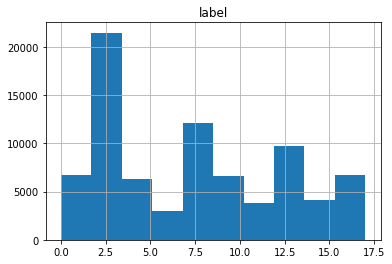

In [4]:
import pandas as pd

df = dataset["train"].to_pandas()

df.hist()

To train our model we need to convert our "Natural Language" to token IDs. This is done by a 🤗 Transformers Tokenizer which will tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary). If you are not sure what this means check out [chapter 6](https://huggingface.co/course/chapter6/1?fw=tf) of the Hugging Face Course.


In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

Additionally we add the `truncation=True` and `padding=max_length` to align the length and truncate texts that are bigger than the maximum size allowed by the model. 

In [ ]:
def process(examples):
    tokenized_inputs = tokenizer(
       examples["text"], padding="max_length", truncation=True
    )
    return tokenized_inputs

tokenized_datasets = dataset.map(process, batched=True)
tokenized_datasets["train"].features

Now that our `dataset` is processed, we can download the pre-trained model and fine-tune it.

## 3. Create a `GaudiTrainer` and an run single HPU fine-tuning

Normally you would use the [Trainer](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.Trainer) and [TrainingArguments](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.TrainingArguments) to fine-tune a pytorch-based transformer model. Since we are using the `optimum-habana` library, we can use the [GaudiTrainer]() and [GaudiTrainingArguments]() instead. The `GaudiTrainer` is a wrapper around the [Trainer](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.Trainer) and [TrainingArguments](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.TrainingArguments) that allows you to fine-tune a transformer model on a gaudi instance, with a similar API to the [Trainer](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.Trainer) and [TrainingArguments](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.TrainingArguments) classes. Below you see how easy it is to migrate from the [Trainer](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.Trainer) and [TrainingArguments](https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/trainer#transformers.TrainingArguments) classes to the [GaudiTrainer]() and [GaudiTrainingArguments]() classes.

```diff
-from transformers import Trainer, TrainingArguments 
+from optimum.habana import GaudiTrainer, GaudiTrainingArguments

# define the training arguments
-training_args = GaudiTrainingArguments(
+training_args = TrainingArguments(
+  use_habana=True,
+  use_lazy_mode=True,
+  gaudi_config_name=path_to_gaudi_config,
  ...
)

# Initialize our Trainer
-trainer = Trainer(
+trainer = GaudiTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
    ... # other arguments
)
```

Before we create our `GaudiTrainer` we first need to define a `compute_metrics` function to evaluate our model on the test set. This function will be used during the training process to compute the `accuracy` & `f1` of our model.

In [7]:
from datasets import load_metric
import numpy as np

# define metrics and metrics function
f1_metric = load_metric("f1")
accuracy_metric = load_metric( "accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="micro")
    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"],
    }

Hyperparameter Definition, Model Loading

In [ ]:
from transformers import AutoModelForSequenceClassification,DataCollatorWithPadding
from optimum.habana import GaudiTrainer, GaudiTrainingArguments
from huggingface_hub import HfFolder

# create label2id, id2label dicts for nice outputs for the model
labels = tokenized_datasets["train"].features["label"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label


# define training args
training_args = GaudiTrainingArguments(
    output_dir=repository_id,
    use_habana=True,
    use_lazy_mode=True,
    gaudi_config_name=gaudi_config_id,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
)

# define model
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=num_labels, 
    id2label=id2label,
    label2id=label2id,
)

# create Trainer
trainer = GaudiTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
# start training on 1x HPU
trainer.train()
# evaluate model
trainer.evaluate(eval_dataset=tokenized_datasets["validation"])

## 4. Run distributed data parallel training with `GaudiTrainer`

running the training only on a single HPU-core takes way to long (5h). Luckily with `DL1` instance we have 8 available HPU-cores meaning we can leverage distributed training. 
To run our training as distributed training we need to create a training script, which can be used with multiprocessing to run on all HPUs. 
We have created a `scripts/train.py` which contains all the previous steps of the example so far. To executed our distributed training we use the `DistributedRunner` runner from `optimum-habana` alternatively you could check-out the [gaudi_spawn.py](https://github.com/huggingface/optimum-habana/blob/main/examples/gaudi_spawn.py) in the [optimum-habana](https://github.com/huggingface/optimum-habana) repository.


In [ ]:
from optimum.habana.distributed import DistributedRunner
from optimum.utils import logging

world_size=8 # Number of HPUs to use (1 or 8)

# define distributed runner
distributed_runner = DistributedRunner(
    command_list=["scripts/train.py --use_habana True"],
    world_size=world_size,
    use_mpi=True,
    multi_hls=False,
)

# start job
ret_code = distributed_runner.run()

## 5. Cost performance benefits of Habana Gaudi1 on AWS

The distributed training on all 8x HPUs took in total 52 minutes. The [dl1.24xlarge](https://aws.amazon.com/ec2/instance-types/dl1/) instance on AWS costs $13.11 per hour leading to only $11,55 for our training. 
To provide a cost-performance comparison we run the same training on the AWS [p3.8xlarge](https://aws.amazon.com/ec2/instance-types/p3/?nc1=h_ls) instance, which costs roughly the same with $12.24, but only has 4x accelerators (4x NVIDIA V100). The training on the p3.8xlarge instance took in total about 439 minutes and cost $89.72.
Meaning the Habana Gaudi instance is **8.4x faster** and **7.7x cheaper** than the price equivalent NVIDIA powered instance. 
Below is a detailed table of results. Additional both models are available on the Hugging Face Hub at [philschmid/habana-xlm-r-large-amazon-massive](https://huggingface.co/philschmid/habana-xlm-r-large-amazon-massive) and [philschmid/gpu-xlm-roberta-large-amazon-massive](https://huggingface.co/philschmid/gpu-xlm-roberta-large-amazon-massive)


| accelerator        | training time (in minutes) | total cost | total batch size | aws instance type                                                    | instance price per hour |
|--------------------|----------------------------|------------|------------------|----------------------------------------------------------------------|-------------------------|
| Habana Gaudi (HPU) | 52.6                       | $11.55     | 64               | [dl1.24xlarge](https://aws.amazon.com/ec2/instance-types/dl1/)       | $13.11                  |
| NVIDIA V100 (GPU)  |     439.8                       |  $89.72          |  4                | [p3.8xlarge](https://aws.amazon.com/ec2/instance-types/p3/?nc1=h_ls) | $12.24                  |


_Note: This comparison currently provides a limited view, since the NVIDIA V100 might not be the best GPU available for training such a large transformer model resulting in a 8x smaller batch size. We plan to run a more detailed cost-performance benchmark including more instances, like NVIDIA A100 and more models, e.g. DistilBERT, GPT-2_

## Conclusion

That's it for this tutorial. Now you know how to fine-tune Hugging Face Transformers on Habana Gaudi using Optimum. You learned how easily you can migrate from a `Trainer` based script to a `GaudiTrainer` based script and how to scale the training to multiple HPUs using the `DistributedRunner`. 

Additionally, we run a simple cost performance benchmark acheiving **8.4x faster** and **7.7x cheaper** training on Habana Gaudi instance than on the price equivalent NVIDIA powered instance. 

Now it is time for you to migrate your training scripts!! 
